# Prepare (Glass + Gunshot) / 准备（玻璃+枪声）

Load multi-source meta, clean and resample all audio to 22.05k mono, then proceed to folds, analysis, and window planning. 读取多源 meta，清洗后重采样为22.05k单声道，继续分折、分析与分窗规划。

## Imports / 导入

In [1]:
import wave
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from IPython.display import display

import librosa
from IPython.display import Audio, display
from src.meta_utils import load_meta_files, map_canonical_labels, deduplicate_meta, sample_gunshot_even, stratified_folds
from src.viz import plot_wave_and_mel
from src.cache_utils import build_cache_index, GLASS_PIPELINE_PLAN
from src.datasets import balance_folds
from src.augment_pipeline import run_pipeline, PIPELINE_REGISTRY
from src.data_utils import load_audio, generate_aligned_windows, trim_silence, log_mel_spectrogram
from src.config import TARGET_LABELS, POSITIVE_LABELS, SEED, SR, PROJECT_ROOT, N_MELS, HOP_LENGTH, BACKGROUND_LABEL, CACHE_ROOT, CACHE_MEL64, META_FILES, RAW_AUDIO_ROOTS


## Config Override / 配置覆写
Set parameters for this run; defaults can move into config later. 设定本次流程参数，后续可移入 config 默认。

In [2]:
META_FILES = META_FILES  # from config
LABEL_MAP = POSITIVE_LABELS
K_FOLDS = 5
RATIOS = {'glass': 3, 'gunshot': 3, 'background': 4}
MAX_DURATION = 6.0  # seconds
GUNSHOT_TARGET = 50  # total gunshot clips after sampling
TARGET_SR = SR
RESAMPLED_ROOT = CACHE_ROOT / 'data_resampled'
INCLUDE_SOURCES = ['esc50', 'gunshot_kaggle']

## Load, map, dedup / 读取映射去重
- Load meta CSVs
- Map raw labels to canonical labels
- Deduplicate by md5/filepath
- Summary counts

读取 meta，映射标签，按 md5/路径去重，打印汇总。

In [3]:
meta_df = load_meta_files(META_FILES)
meta_df = map_canonical_labels(meta_df, label_map=LABEL_MAP, target_labels=TARGET_LABELS)
meta_df = deduplicate_meta(meta_df, subset=['md5','filepath'])
print('Total rows after dedup:', len(meta_df))
print('By source (all):', meta_df['source'].value_counts().to_dict(),'\n')

INCLUDE_SOURCES = ['esc50', 'gunshot_kaggle']
working_df = meta_df[meta_df['source'].isin(INCLUDE_SOURCES)].copy()
holdout_df = meta_df[~meta_df['source'].isin(INCLUDE_SOURCES)].copy()
print('Working sources:', INCLUDE_SOURCES, '->', working_df['source'].value_counts().to_dict())
print('Working labels:', working_df['canonical_label'].value_counts().to_dict())
print('Holdout sources:', holdout_df['source'].value_counts().to_dict())
print('Holdout labels:', holdout_df['canonical_label'].value_counts().to_dict())


Total rows after dedup: 2870
By source (all): {'esc50': 2000, 'gunshot_kaggle': 851, 'freesound': 19} 

Working sources: ['esc50', 'gunshot_kaggle'] -> {'esc50': 2000, 'gunshot_kaggle': 851}
Working labels: {'gunshot': 851, 'snoring': 40, 'rain': 40, 'insects': 40, 'laughing': 40, 'hen': 40, 'engine': 40, 'breathing': 40, 'crying_baby': 40, 'hand_saw': 40, 'coughing': 40, 'glass': 40, 'toilet_flush': 40, 'helicopter': 40, 'pig': 40, 'washing_machine': 40, 'clock_tick': 40, 'sneezing': 40, 'rooster': 40, 'sea_waves': 40, 'siren': 40, 'cat': 40, 'door_wood_creaks': 40, 'crickets': 40, 'drinking_sipping': 40, 'dog': 40, 'chirping_birds': 40, 'pouring_water': 40, 'vacuum_cleaner': 40, 'thunderstorm': 40, 'door_wood_knock': 40, 'can_opening': 40, 'crow': 40, 'clapping': 40, 'fireworks': 40, 'chainsaw': 40, 'airplane': 40, 'mouse_click': 40, 'train': 40, 'car_horn': 40, 'sheep': 40, 'water_drops': 40, 'church_bells': 40, 'clock_alarm': 40, 'keyboard_typing': 40, 'wind': 40, 'footsteps': 40, 

## Filter & gunshot sampling / 过滤与枪声抽样
- Drop clips longer than MAX_DURATION
- Evenly sample gunshot across weapon_id to total GUNSHOT_TARGET

过滤 >MAX_DURATION；枪声按 weapon_id 均匀抽样，总数 GUNSHOT_TARGET。

In [4]:
clean_df = working_df[working_df['duration_sec'] <= MAX_DURATION].copy()
gun_sampled = sample_gunshot_even(clean_df, target_label='gunshot', total=GUNSHOT_TARGET, seed=SEED)
if not gun_sampled.empty:
    gun_stats = gun_sampled.groupby('source').size().to_dict()
    weapon_stats = gun_sampled.apply(lambda r: Path(str(r.get('filepath',''))).parent.name, axis=1).value_counts().to_dict()
    print('Gunshot sampled per source:', gun_stats)
    print('Gunshot sampled per weapon_id (from parent folder):', weapon_stats, '\n')
    
non_gun = clean_df[clean_df['canonical_label'] != 'gunshot']
clean_df = pd.concat([non_gun, gun_sampled], ignore_index=True)
print(f'Label counts: （{len(clean_df)})', clean_df['canonical_label'].value_counts().to_dict())



Gunshot sampled per source: {'gunshot_kaggle': 50}
Gunshot sampled per weapon_id (from parent folder): {'AK-12': 6, 'AK-47': 6, 'M16': 6, 'MG-42': 6, 'MP5': 6, 'IMI Desert Eagle': 5, 'M249': 5, 'M4': 5, 'Zastava M92': 5} 

Label counts: （2050) {'gunshot': 50, 'snoring': 40, 'rain': 40, 'insects': 40, 'laughing': 40, 'hen': 40, 'engine': 40, 'breathing': 40, 'crying_baby': 40, 'hand_saw': 40, 'coughing': 40, 'glass': 40, 'toilet_flush': 40, 'helicopter': 40, 'pig': 40, 'washing_machine': 40, 'clock_tick': 40, 'sneezing': 40, 'rooster': 40, 'sea_waves': 40, 'siren': 40, 'cat': 40, 'door_wood_creaks': 40, 'crickets': 40, 'drinking_sipping': 40, 'dog': 40, 'chirping_birds': 40, 'pouring_water': 40, 'vacuum_cleaner': 40, 'thunderstorm': 40, 'door_wood_knock': 40, 'can_opening': 40, 'crow': 40, 'clapping': 40, 'fireworks': 40, 'chainsaw': 40, 'airplane': 40, 'mouse_click': 40, 'train': 40, 'car_horn': 40, 'sheep': 40, 'water_drops': 40, 'church_bells': 40, 'clock_alarm': 40, 'keyboard_typing

## Resample to 22.05k mono / 重采样为22.05k单声道
Write resampled audio to cache/data_resampled and build resampled_df. 将重采样音频写到 cache/data_resampled，并生成 resampled_df。
⚠️ Loads & writes all clips; may take time/disk. 需加载并写出全部音频，耗时且占用磁盘。

In [5]:
RESAMPLED_ROOT = RESAMPLED_ROOT
resampled_rows = []
for _, r in clean_df.iterrows():
    y_rs, sr_rs = load_audio(r, sr=TARGET_SR)
    rel = Path(r['filepath'])
    if rel.is_absolute():
        rel = rel.relative_to(PROJECT_ROOT)
    dst_path = RESAMPLED_ROOT / rel
    dst_path.parent.mkdir(parents=True, exist_ok=True)
    y_int16 = (y_rs * 32767).clip(-32768, 32767).astype('int16')
    with wave.open(dst_path.as_posix(), 'wb') as wf:
        wf.setnchannels(1)
        wf.setsampwidth(2)
        wf.setframerate(TARGET_SR)
        wf.writeframes(y_int16.tobytes())
    frames = len(y_int16)
    resampled_rows.append({
        'sno': r.get('sno', len(resampled_rows)+1),
        'raw_filepath': rel.as_posix(),
        'filepath': dst_path.relative_to(PROJECT_ROOT).as_posix(),
        'label': r.get('label'),
        'canonical_label': r.get('canonical_label'),
        'source': r.get('source'),
        'fold_id': r.get('fold_id',''),
        'duration_sec': round(frames / TARGET_SR, 3),
        'duration_samples': frames,
        'sr': TARGET_SR,
        'channels': 1,
        'bit_depth': 16,
        'md5': '',
        'extra_meta': r.get('extra_meta',''),
    })
resampled_df = pd.DataFrame(resampled_rows)
resampled_df['target_label'] = resampled_df['canonical_label']
print('Resampled rows:', len(resampled_df))
print('sr/ch after resample:', resampled_df['sr'].unique(), resampled_df['channels'].unique())
print('Label counts:', resampled_df['target_label'].value_counts().to_dict())


Resampled rows: 2050
sr/ch after resample: [22050] [1]
Label counts: {'gunshot': 50, 'snoring': 40, 'rain': 40, 'insects': 40, 'laughing': 40, 'hen': 40, 'engine': 40, 'breathing': 40, 'crying_baby': 40, 'hand_saw': 40, 'coughing': 40, 'glass': 40, 'toilet_flush': 40, 'helicopter': 40, 'pig': 40, 'washing_machine': 40, 'clock_tick': 40, 'sneezing': 40, 'rooster': 40, 'sea_waves': 40, 'siren': 40, 'cat': 40, 'door_wood_creaks': 40, 'crickets': 40, 'drinking_sipping': 40, 'dog': 40, 'chirping_birds': 40, 'pouring_water': 40, 'vacuum_cleaner': 40, 'thunderstorm': 40, 'door_wood_knock': 40, 'can_opening': 40, 'crow': 40, 'clapping': 40, 'fireworks': 40, 'chainsaw': 40, 'airplane': 40, 'mouse_click': 40, 'train': 40, 'car_horn': 40, 'sheep': 40, 'water_drops': 40, 'church_bells': 40, 'clock_alarm': 40, 'keyboard_typing': 40, 'wind': 40, 'footsteps': 40, 'frog': 40, 'cow': 40, 'brushing_teeth': 40, 'crackling_fire': 40}


In [6]:
# Optional: save holdout meta for later use
if len(holdout_df) > 0:
    holdout_path = RESAMPLED_ROOT / 'holdout_meta.csv'
    holdout_path.parent.mkdir(parents=True, exist_ok=True)
    holdout_df.to_csv(holdout_path, index=False)
    print('Saved holdout meta to', holdout_path)


Saved holdout meta to /workspace/cache/data_resampled/holdout_meta.csv


## Listen: before vs after / 试听前后
Play original vs resampled audio for a few samples. 对比播放原始与重采样音频。

In [7]:
samples = resampled_df.sample(n=min(5, len(resampled_df)), random_state=SEED)
for _, r in samples.iterrows():
    y_after, sr_after = load_audio(r, sr=TARGET_SR)
    raw_rel = Path(r.get('raw_filepath', r['filepath']))
    raw_path = PROJECT_ROOT / raw_rel if not raw_rel.is_absolute() else raw_rel
    y_before, sr_before = (None, None)
    if raw_path.exists():
        y_before, sr_before = load_audio({'filepath': raw_path}, sr=None)
    print('Sample:', r.get('target_label',''), '|', raw_rel)
    if y_before is not None:
        display(Audio(y_before, rate=sr_before))
    display(Audio(y_after, rate=sr_after))
    print('-'*40)


Sample: crow | data/esc50/audio/5-213836-B-9.wav


----------------------------------------
Sample: siren | data/esc50/audio/2-70052-B-42.wav


----------------------------------------
Sample: snoring | data/esc50/audio/3-130998-A-28.wav


----------------------------------------
Sample: sneezing | data/esc50/audio/2-130978-A-21.wav


----------------------------------------
Sample: sea_waves | data/esc50/audio/5-219379-B-11.wav


----------------------------------------


folded_df = stratified_folds(resampled_df, k=K_FOLDS, seed=SEED, group_key='canonical_label', sub_key=None, fold_column='fold_id')
print('Fold distribution (counts):', folded_df['fold_id'].value_counts().to_dict())
fold_pivot = folded_df.pivot_table(index='target_label', columns='fold_id', values='filepath', aggfunc='count').fillna(0).astype(int)
print('Label x fold (counts):')
print(fold_pivot.to_string())


In [8]:
folded_df = stratified_folds(resampled_df, k=K_FOLDS, seed=SEED, group_key='canonical_label', sub_key=None, fold_column='fold_id')
print('Fold distribution (counts):', folded_df['fold_id'].value_counts().to_dict())
fold_pivot = folded_df.pivot_table(index='target_label', columns='fold_id', values='filepath', aggfunc='count').fillna(0).astype(int)
print('Label x fold (counts):')
display(fold_pivot)

Fold distribution (counts): {1: 410, 2: 410, 3: 410, 4: 410, 5: 410}
Label x fold (counts):


fold_id            1   2   3   4   5
target_label                        
airplane           8   8   8   8   8
breathing          8   8   8   8   8
brushing_teeth     8   8   8   8   8
can_opening        8   8   8   8   8
car_horn           8   8   8   8   8
cat                8   8   8   8   8
chainsaw           8   8   8   8   8
chirping_birds     8   8   8   8   8
church_bells       8   8   8   8   8
clapping           8   8   8   8   8
clock_alarm        8   8   8   8   8
clock_tick         8   8   8   8   8
coughing           8   8   8   8   8
cow                8   8   8   8   8
crackling_fire     8   8   8   8   8
crickets           8   8   8   8   8
crow               8   8   8   8   8
crying_baby        8   8   8   8   8
dog                8   8   8   8   8
door_wood_creaks   8   8   8   8   8
door_wood_knock    8   8   8   8   8
drinking_sipping   8   8   8   8   8
engine             8   8   8   8   8
fireworks          8   8   8   8   8
footsteps          8   8   8   8   8
frog               8   8   8   8   8
glass              8   8   8   8   8
gunshot           10  10  10  10  10
hand_saw           8   8   8   8   8
helicopter         8   8   8   8   8
hen                8   8   8   8   8
insects            8   8   8   8   8
keyboard_typing    8   8   8   8   8
laughing           8   8   8   8   8
mouse_click        8   8   8   8   8
pig                8   8   8   8   8
pouring_water      8   8   8   8   8
rain               8   8   8   8   8
rooster            8   8   8   8   8
sea_waves          8   8   8   8   8
sheep              8   8   8   8   8
siren              8   8   8   8   8
sneezing           8   8   8   8   8
snoring            8   8   8   8   8
thunderstorm       8   8   8   8   8
toilet_flush       8   8   8   8   8
train              8   8   8   8   8
vacuum_cleaner     8   8   8   8   8
washing_machine    8   8   8   8   8
water_drops        8   8   8   8   8
wind               8   8   8   8   8

## Visual sanity check / 随机样本可视化
Plot wave and log-mel for a random resampled sample. 随机抽样画波形与 log-mel（已重采样）。

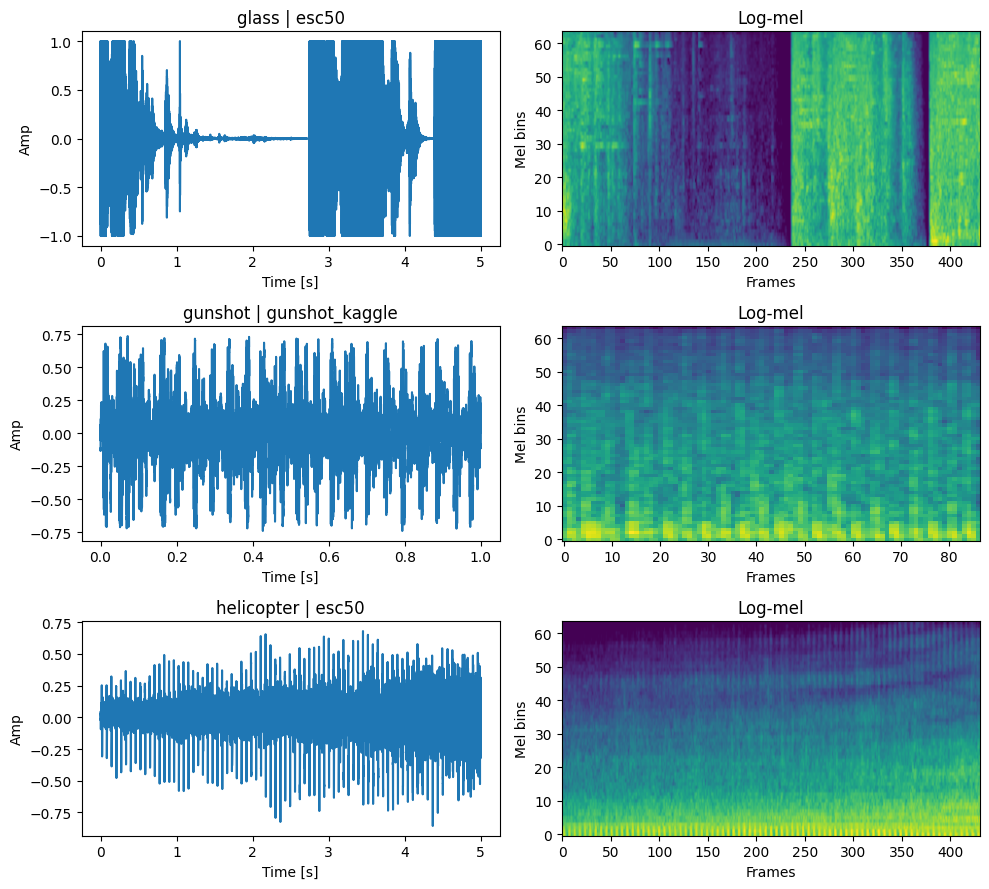

In [9]:
## Visual sanity check / 随机样本可视化
# Pick one glass, one gunshot (if available), and one background for wave+mel.
labels_for_viz = ['glass','gunshot', BACKGROUND_LABEL]
samples = []
for lbl in labels_for_viz:
    subset = folded_df[folded_df['target_label']==lbl]
    if len(subset) == 0:
        continue
    samples.append(subset.sample(random_state=SEED).iloc[0])
if not any(s.get('target_label') == BACKGROUND_LABEL for s in samples):
    bg_pool = folded_df[~folded_df['target_label'].isin(['glass','gunshot'])]
    if len(bg_pool) > 0:
        samples.append(bg_pool.sample(random_state=SEED).iloc[0])
n = len(samples)
if n == 0:
    print('No samples available for viz')
else:
    fig, axes = plt.subplots(n, 2, figsize=(10, 3*n))
    if n == 1:
        axes = np.array([axes])
    for idx, row in enumerate(samples):
        y, sr = load_audio(row, sr=TARGET_SR)
        times = np.arange(len(y)) / sr
        axes[idx][0].plot(times, y)
        axes[idx][0].set_title(f"{row['target_label']} | {row['source']}")
        axes[idx][0].set_xlabel('Time [s]')
        axes[idx][0].set_ylabel('Amp')
        mel = log_mel_spectrogram(y, sr, n_fft=HOP_LENGTH*4, hop_length=HOP_LENGTH, n_mels=N_MELS)
        axes[idx][1].imshow(mel, aspect='auto', origin='lower')
        axes[idx][1].set_title('Log-mel')
        axes[idx][1].set_xlabel('Frames')
        axes[idx][1].set_ylabel('Mel bins')
    plt.tight_layout()
    plt.show()


## Energy analysis (glass & gunshot) / 能量分析
Sample clips, compute RMS/duration for window tuning. 抽样计算 RMS/时长供窗口调节。

Duration stats:
         mean  min  max
label                  
glass    5.00  5.0  5.0
gunshot  1.85  1.0  3.0
RMS max stats:
             mean       min       max
label                                
glass    0.306044  0.039080  0.844143
gunshot  0.275073  0.094387  0.553042


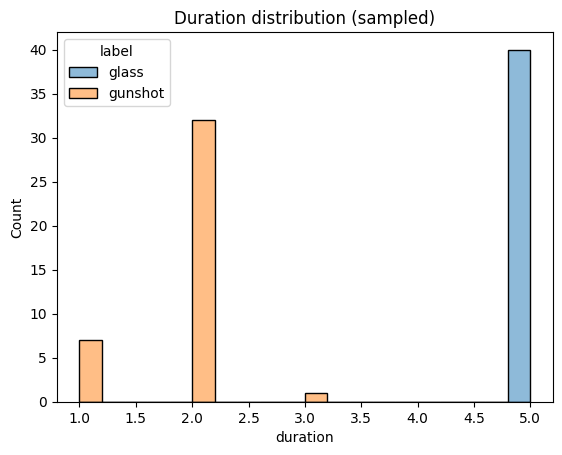

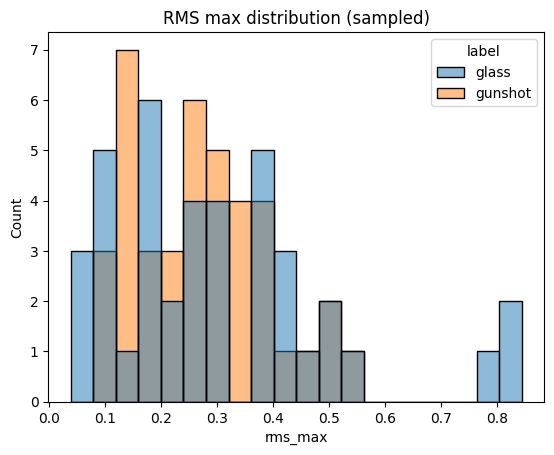

In [10]:
samples_energy = []
for lbl in ['glass','gunshot']:
    sub = folded_df[folded_df['target_label']==lbl]
    sub = sub.sample(n=min(40, len(sub)), random_state=SEED)
    for _, row in sub.iterrows():
        y, sr = load_audio(row, sr=TARGET_SR)
        rms = librosa.feature.rms(y=y, frame_length=2048, hop_length=256)[0]
        samples_energy.append({'label': lbl, 'duration': len(y)/sr, 'rms_max': float(rms.max())})
energy_df = pd.DataFrame(samples_energy)
print('Duration stats:')
print(energy_df.groupby('label')['duration'].agg(['mean','min','max']))
print('RMS max stats:')
print(energy_df.groupby('label')['rms_max'].agg(['mean','min','max']))
sns.histplot(data=energy_df, x='duration', hue='label', bins=20)
plt.title('Duration distribution (sampled)')
plt.show()
sns.histplot(data=energy_df, x='rms_max', hue='label', bins=20)
plt.title('RMS max distribution (sampled)')
plt.show()


### Detailed energy/peak stats / 能量与峰值细查 (统计峰值位置、活跃占比，辅助判断窗口/裁剪参数)。

Energy detail (mean/median/95%)


duration                      rms_max                        peak_pos  \
            mean median _quantile95      mean    median _quantile95      mean   
label                                                                           
glass       5.00    5.0         5.0  0.209752  0.170075    0.775977  0.150000   
gunshot     1.86    2.0         2.0  0.221434  0.191545    0.416965  0.471667   

                           active_ratio                        
        median _quantile95         mean    median _quantile95  
label                                                          
glass      0.1    0.605000     0.188636  0.136364    0.459091  
gunshot    0.5    0.795833     0.661714  0.600000    1.000000

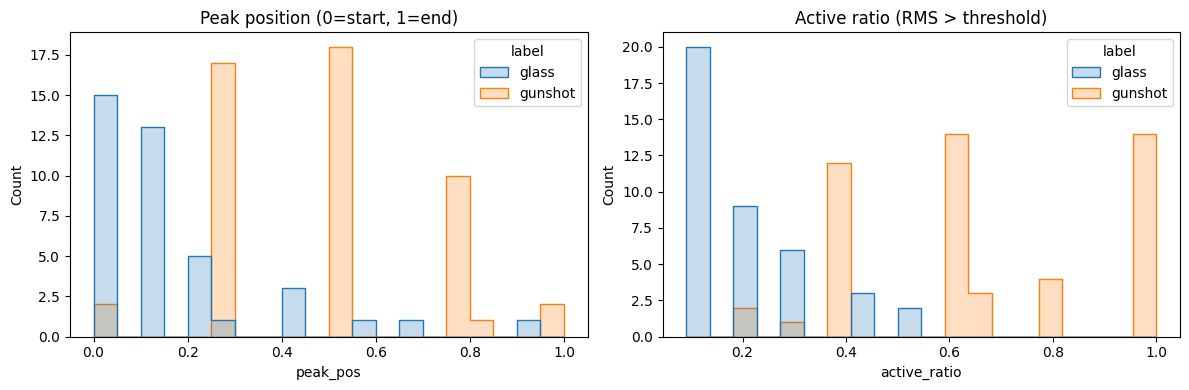

In [11]:
from functools import partial

# Defaults if config cell not run yet
WINDOW_SECONDS = globals().get('WINDOW_SECONDS', 1.0)
WINDOW_HOP = globals().get('WINDOW_HOP', 0.5)
ENERGY_THRESHOLD = globals().get('ENERGY_THRESHOLD', 0.3)
TRIM_SILENCE_BEFORE = globals().get('TRIM_SILENCE_BEFORE', False)
TRIM_TOP_DB = globals().get('TRIM_TOP_DB', 20.0)
TRIM_MIN_KEEP_SECONDS = globals().get('TRIM_MIN_KEEP_SECONDS', 0.0)


def _quantile95(x):
    return x.quantile(0.95)

def compute_energy_detail(sub_df, sample_n=80):
    rows = []
    if len(sub_df) == 0:
        return pd.DataFrame(rows)
    sample = sub_df.sample(n=min(sample_n, len(sub_df)), random_state=SEED)
    for _, r in sample.iterrows():
        y, sr = load_audio(r, sr=TARGET_SR)
        if TRIM_SILENCE_BEFORE:
            y = trim_silence(y, sr, top_db=TRIM_TOP_DB, min_keep_seconds=TRIM_MIN_KEEP_SECONDS)
        frame_length = min(2048, int(WINDOW_SECONDS * sr))
        hop = int(WINDOW_HOP * sr)
        rms = librosa.feature.rms(y=y, frame_length=frame_length, hop_length=hop)[0]
        if rms.size == 0 or rms.max() <= 0:
            continue
        peak_idx = int(np.argmax(rms))
        peak_pos = peak_idx / max(len(rms) - 1, 1)
        active_ratio = float((rms > (rms.max() * ENERGY_THRESHOLD)).sum()) / len(rms)
        rows.append({
            'duration': len(y) / sr,
            'rms_max': float(rms.max()),
            'peak_pos': peak_pos,
            'active_ratio': active_ratio,
        })
    return pd.DataFrame(rows)

energy_detail = []
for lbl in ['glass', 'gunshot']:
    df_lbl = folded_df[folded_df['target_label'] == lbl]
    stats = compute_energy_detail(df_lbl)
    stats['label'] = lbl
    energy_detail.append(stats)
energy_detail = pd.concat(energy_detail, ignore_index=True)
print('Energy detail (mean/median/95%)')
display(energy_detail.groupby('label')[['duration', 'rms_max', 'peak_pos', 'active_ratio']].agg(['mean', 'median', _quantile95]))

fig, axes = plt.subplots(1, 2, figsize=(12, 4))
sns.histplot(data=energy_detail, x='peak_pos', hue='label', bins=20, ax=axes[0], element='step')
axes[0].set_title('Peak position (0=start, 1=end)')
sns.histplot(data=energy_detail, x='active_ratio', hue='label', bins=20, ax=axes[1], element='step')
axes[1].set_title('Active ratio (RMS > threshold)')
plt.tight_layout(); plt.show()


## Window config / 分窗配置
Override window/threshold parameters for this session. 本次会话窗口/阈值参数。

In [12]:
WINDOW_SECONDS = 1.0
WINDOW_HOP = 0.5
ENERGY_THRESHOLD = 0.3
PEAK_RATIO_THRESHOLD = 0.8
FRONT_PEAK_RATIO = 0.5
EXTRA_SHIFTS = (-0.1, 0.1)
TRIM_SILENCE_BEFORE = True
TRIM_TOP_DB = 20.0
TRIM_MIN_KEEP_SECONDS = 0.2
cfg_rows = [
    ('WINDOW_SECONDS', WINDOW_SECONDS, 'window length (s): longer=more context, shorter=less latency but may miss long events'),
    ('WINDOW_HOP', WINDOW_HOP, 'hop (s): smaller=denser windows, larger=fewer windows/less overlap'),
    ('ENERGY_THRESHOLD', ENERGY_THRESHOLD, 'energy mask threshold (relative): higher=drop quiet windows, lower=keep more'),
    ('PEAK_RATIO_THRESHOLD', PEAK_RATIO_THRESHOLD, 'peak energy ratio (relative to clip): higher=only strong peaks kept'),
    ('FRONT_PEAK_RATIO', FRONT_PEAK_RATIO, 'peak position limit (0-1): lower=peaks must be earlier'),
    ('EXTRA_SHIFTS', EXTRA_SHIFTS, 'fallback shifts (s) when no peak windows kept'),
    ('TRIM_SILENCE_BEFORE', TRIM_SILENCE_BEFORE, 'apply silence trim before windowing'),
    ('TRIM_TOP_DB', TRIM_TOP_DB, 'trim threshold dB: higher=more aggressive trimming'),
    ('TRIM_MIN_KEEP_SECONDS', TRIM_MIN_KEEP_SECONDS, 'min segment kept after trim (s)')
]
print('Windowing / energy config:')
for k,v,desc in cfg_rows:
    print(f'- {k}: {v} -> {desc}')


Windowing / energy config:
- WINDOW_SECONDS: 1.0 -> window length (s): longer=more context, shorter=less latency but may miss long events
- WINDOW_HOP: 0.5 -> hop (s): smaller=denser windows, larger=fewer windows/less overlap
- ENERGY_THRESHOLD: 0.3 -> energy mask threshold (relative): higher=drop quiet windows, lower=keep more
- PEAK_RATIO_THRESHOLD: 0.8 -> peak energy ratio (relative to clip): higher=only strong peaks kept
- FRONT_PEAK_RATIO: 0.5 -> peak position limit (0-1): lower=peaks must be earlier
- EXTRA_SHIFTS: (-0.1, 0.1) -> fallback shifts (s) when no peak windows kept
- TRIM_SILENCE_BEFORE: True -> apply silence trim before windowing
- TRIM_TOP_DB: 20.0 -> trim threshold dB: higher=more aggressive trimming
- TRIM_MIN_KEEP_SECONDS: 0.2 -> min segment kept after trim (s)


## Base window summary / 基础分窗统计
Generate aligned windows for glass & gunshot, count per clip. 对玻璃/枪声分窗，统计每clip窗口数。

Total clips: 90, total windows: 123

Windows per label:


clips  windows  mean  max
label                             
glass       40       60  1.50    8
gunshot     50       63  1.26    3


Windows per fold x label:


sum         count          mean        
label glass gunshot glass gunshot glass gunshot
fold                                           
1         8      12     8      10  1.00     1.2
2        12      12     8      10  1.50     1.2
3        10      12     8      10  1.25     1.2
4         8      13     8      10  1.00     1.3
5        22      14     8      10  2.75     1.4

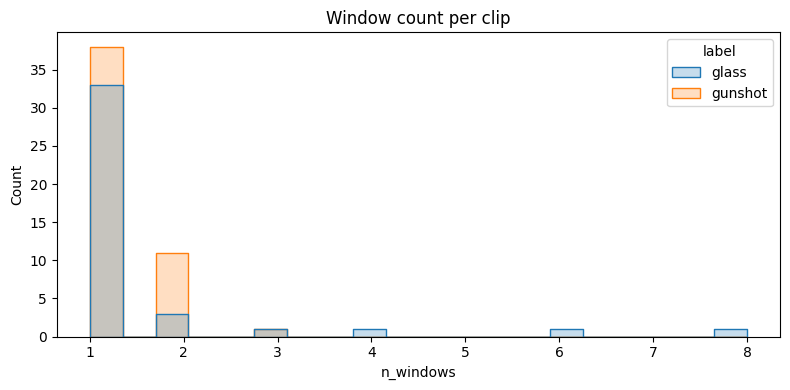

In [13]:
records = []
subset = folded_df[folded_df['target_label'].isin(['glass','gunshot'])]
for _, row in subset.iterrows():
    wins = generate_aligned_windows(
        row,
        align_labels=['glass', 'gunshot'],
        extra_shifts=EXTRA_SHIFTS,
        energy_threshold=ENERGY_THRESHOLD,
        peak_ratio_threshold=PEAK_RATIO_THRESHOLD,
        front_peak_ratio=FRONT_PEAK_RATIO,
        trim_silence_before=TRIM_SILENCE_BEFORE,
        trim_top_db=TRIM_TOP_DB,
        trim_min_keep_seconds=TRIM_MIN_KEEP_SECONDS,
    )
    records.append({
        'label': row['target_label'],
        'fold': row.get('fold_id', -1),
        'clip': Path(row['filepath']).stem,
        'n_windows': len(wins),
    })
base_df = pd.DataFrame(records)

if len(base_df) == 0:
    print('No windows found')
else:
    total_windows = int(base_df['n_windows'].sum())
    print(f"Total clips: {len(base_df)}, total windows: {total_windows}")
    print('\nWindows per label:')
    display(base_df.groupby('label')['n_windows'].agg(['count','sum','mean','max']).rename(columns={'count':'clips','sum':'windows'}))
    if 'fold' in base_df.columns:
        print('\nWindows per fold x label:')
        pivot = base_df.pivot_table(index='fold', columns='label', values='n_windows', aggfunc=['sum','count','mean']).fillna(0)
        display(pivot)
    fig, ax = plt.subplots(figsize=(8,4))
    sns.histplot(data=base_df, x='n_windows', hue='label', bins=20, element='step')
    ax.set_title('Window count per clip')
    plt.tight_layout(); plt.show()


### Multi-window clips / 多窗样本榜单列出窗口数较多的样本，优先抽查质检。

In [14]:
MULTI_WINDOW_THRESHOLD = 3
multi_df = base_df[base_df['n_windows'] >= MULTI_WINDOW_THRESHOLD].sort_values('n_windows', ascending=False)
print(f"Clips with >= {MULTI_WINDOW_THRESHOLD} windows: {len(multi_df)}")
if len(multi_df):
    display(multi_df[['clip','label','fold','n_windows']].head(25))
else:
    print('No multi-window clips')


Clips with >= 3 windows: 5


clip    label  fold  n_windows
14  4-204777-A-39    glass     5          8
19  4-204777-B-39    glass     5          6
21  4-204777-C-39    glass     2          4
34  2-112213-B-39    glass     5          3
79         6 (26)  gunshot     5          3

## Window QA visualization / 分窗可视化QA
Plot waveform+RMS with kept window boundaries for one glass and one gunshot sample. 对玻璃/枪声各选一条，画波形+RMS并标出保留的窗口边界。



=== Sample 1: glass | esc50 | cache/data_resampled/data/esc50/audio/5-221529-A-39.wav
Full clip (5.00s)


[SKIP partial overlap] t=0.00s
[SKIP partial overlap] t=0.50s
[SKIP silent trim] t=1.00s
[SKIP silent trim] t=1.50s
[SKIP silent trim] t=2.00s
[SKIP silent trim] t=2.50s
[SKIP silent trim] t=3.00s
[SKIP silent trim] t=3.50s
[SKIP silent trim] t=4.00s
[FALLBACK] center_peak_window shift=0.0


start_sec  end_sec peak_ratio peak_position status  \
0         NaN      NaN       None          None   info   
1         0.0      1.0       None          None   skip   
2         0.5      1.5       None          None   skip   
3         1.0      2.0       None          None   skip   
4         1.5      2.5       None          None   skip   
5         2.0      3.0       None          None   skip   
6         2.5      3.5       None          None   skip   
7         3.0      4.0       None          None   skip   
8         3.5      4.5       None          None   skip   
9         4.0      5.0       None          None   skip   
10        NaN      NaN       None          None   keep   

                                               reason  
0   windows_raw=9 windows_trim=1 len_raw=5.00s len...  
1                                partial_trim_overlap  
2                                partial_trim_overlap  
3                                         silent_trim  
4                                         silent_trim  
5                                         silent_trim  
6                                         silent_trim  
7                                         silent_trim  
8                                         silent_trim  
9                                         silent_trim  
10                                 fallback_shift_0.0

Length raw=5.00s after_trim=0.46s


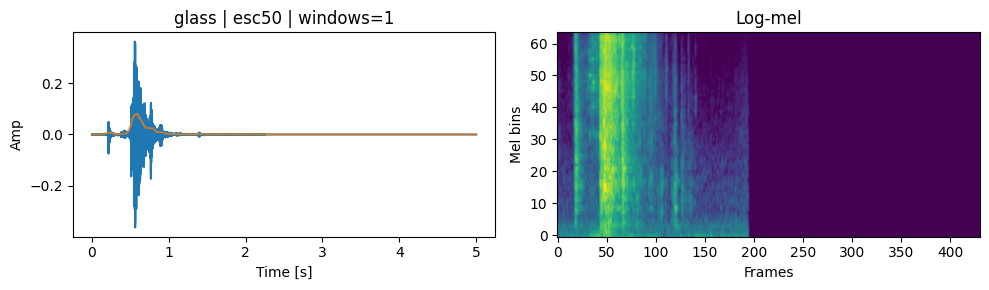

Play window 0: 0.00s - 1.00s



=== Sample 2: gunshot | gunshot_kaggle | cache/data_resampled/data/gunshot_kaggle/MP5/8 (49).wav
Full clip (2.00s)


[SKIP late peak] t=0.00s peak_ratio=1.000 pos=0.625
[SKIP partial overlap] t=0.50s
[SKIP partial overlap] t=1.00s
[FALLBACK] center_peak_window shift=0.0


start_sec  end_sec  peak_ratio  peak_position status  \
0        NaN      NaN         NaN            NaN   info   
1        0.0      1.0         1.0       0.624762   skip   
2        0.5      1.5         NaN            NaN   skip   
3        1.0      2.0         NaN            NaN   skip   
4        NaN      NaN         NaN            NaN   keep   

                                              reason  
0  windows_raw=3 windows_trim=1 len_raw=2.00s len...  
1                                          late_peak  
2                               partial_trim_overlap  
3                               partial_trim_overlap  
4                                 fallback_shift_0.0

Length raw=2.00s after_trim=1.25s


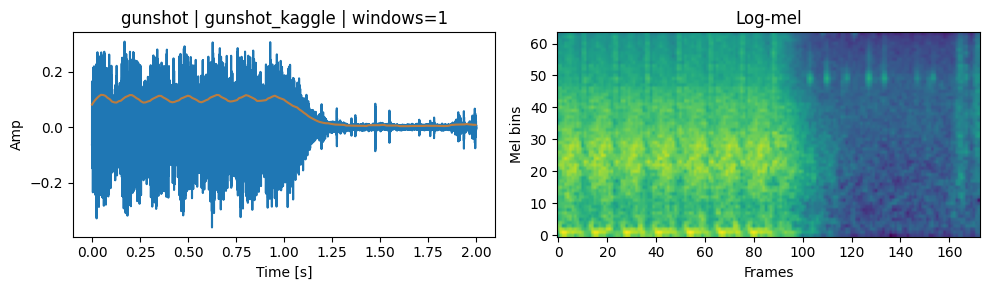

Play window 0: 0.00s - 1.00s



=== Sample 3: footsteps | esc50 | cache/data_resampled/data/esc50/audio/3-103597-A-25.wav
Full clip (5.00s)


[KEEP bg] t=0.00s mask=True
[KEEP bg] t=0.50s mask=True
[SKIP bg energy] t=1.00s mask=False
[SKIP bg energy] t=1.50s mask=False
[SKIP bg energy] t=2.00s mask=False
[SKIP bg energy] t=2.50s mask=False
[SKIP bg energy] t=3.00s mask=False
[SKIP bg energy] t=3.50s mask=False
[SKIP bg silent trim] t=4.00s


start_sec  end_sec peak_ratio peak_position status  \
0        NaN      NaN       None          None   info   
1        0.0      1.0       None          None   keep   
2        0.5      1.5       None          None   keep   
3        1.0      2.0       None          None   skip   
4        1.5      2.5       None          None   skip   
5        2.0      3.0       None          None   skip   
6        2.5      3.5       None          None   skip   
7        3.0      4.0       None          None   skip   
8        3.5      4.5       None          None   skip   
9        4.0      5.0       None          None   skip   

                                              reason  
0  windows_raw=9 windows_trim=6 len_raw=5.00s len...  
1                                               pass  
2                                               pass  
3                                         mask_false  
4                                         mask_false  
5                                         mask_false  
6                                         mask_false  
7                                         mask_false  
8                                         mask_false  
9                                        silent_trim

Length raw=5.00s after_trim=3.60s


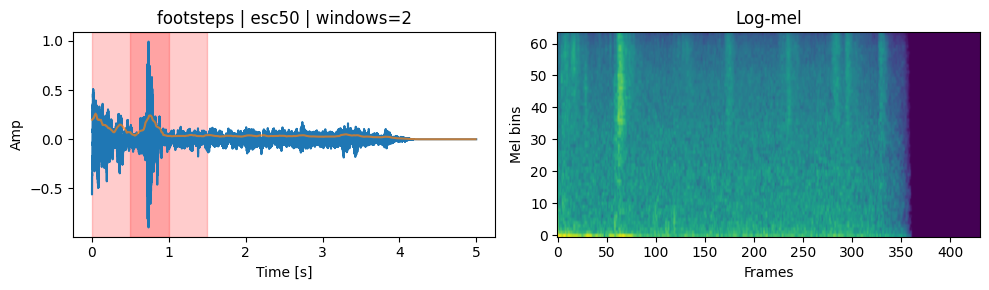

Play window 0: 0.00s - 1.00s


Play window 1: 0.50s - 1.50s


In [25]:
SEED = 1

## Window QA (combined viz + listening) / 分窗 QA（可视化+试听）
# Sample one glass, one gunshot, one background (if available); visualize windows and listen to kept windows.
samples_cfg = ['glass','gunshot', BACKGROUND_LABEL]
samples = []
for lbl in samples_cfg:
    subset = folded_df[folded_df['target_label']==lbl]
    if len(subset) == 0:
        continue
    samples.append(subset.sample(random_state=SEED).iloc[0])
if not any(s.get('target_label') == BACKGROUND_LABEL for s in samples):
    bg_pool = folded_df[~folded_df['target_label'].isin(['glass','gunshot'])]
    if len(bg_pool) > 0:
        samples.append(bg_pool.sample(random_state=SEED).iloc[0])
if len(samples) == 0:
    print('No samples available for QA')
else:
    for idx, row in enumerate(samples):
        print(f"\n=== Sample {idx+1}: {row.get('target_label','')} | {row.get('source','')} | {row.get('filepath','')}")
        y, sr = load_audio(row, sr=TARGET_SR)
        print(f"Full clip ({len(y)/sr:.2f}s)")
        display(Audio(y, rate=sr))
        # 记录窗口决策日志
        logs = []
        wins = generate_aligned_windows(
            row,
            align_labels=['glass','gunshot'],
            extra_shifts=EXTRA_SHIFTS,
            energy_threshold=ENERGY_THRESHOLD,
            peak_ratio_threshold=PEAK_RATIO_THRESHOLD,
            front_peak_ratio=FRONT_PEAK_RATIO,
            trim_silence_before=TRIM_SILENCE_BEFORE,
            trim_top_db=TRIM_TOP_DB,
            trim_min_keep_seconds=TRIM_MIN_KEEP_SECONDS,
            debug=True,
            debug_sink=logs,
        )
        # 打印日志表，便于查看被丢弃原因
        if logs:
            import pandas as pd
            display(pd.DataFrame(logs))
        # 记录修剪前后长度
        if TRIM_SILENCE_BEFORE:
            y_trim = trim_silence(y, sr, top_db=TRIM_TOP_DB, min_keep_seconds=TRIM_MIN_KEEP_SECONDS)
            print(f"Length raw={len(y)/sr:.2f}s after_trim={len(y_trim)/sr:.2f}s")
        hop_len = int(WINDOW_HOP * sr)
        win_len = int(WINDOW_SECONDS * sr)
        fig, axes = plt.subplots(1, 2, figsize=(10, 3))
        times = np.arange(len(y)) / sr
        axes[0].plot(times, y)
        axes[0].set_title(f"{row['target_label']} | {row['source']} | windows={len(wins)}")
        axes[0].set_xlabel('Time [s]')
        axes[0].set_ylabel('Amp')
        rms = librosa.feature.rms(y=y, frame_length=2048, hop_length=256)[0]
        rms_times = (np.arange(len(rms)) * 256) / sr
        axes[0].plot(rms_times, rms, alpha=0.7)
        # 使用日志中的 start_sec 标记被保留的窗口
        kept_starts = [l['start_sec'] for l in logs if l.get('status') == 'keep' and l.get('start_sec') is not None]
        for start_sec in kept_starts:
            axes[0].axvspan(start_sec, start_sec + WINDOW_SECONDS, color='red', alpha=0.2)
        mel = log_mel_spectrogram(y, sr, n_fft=HOP_LENGTH*4, hop_length=HOP_LENGTH, n_mels=N_MELS)
        axes[1].imshow(mel, aspect='auto', origin='lower')
        axes[1].set_title('Log-mel')
        axes[1].set_xlabel('Frames')
        axes[1].set_ylabel('Mel bins')
        plt.tight_layout(); plt.show()
        for w_idx, w in enumerate(wins):
            start = kept_starts[w_idx] if w_idx < len(kept_starts) else w_idx * hop_len / sr
            end = start + WINDOW_SECONDS
            print(f"Play window {w_idx}: {start:.2f}s - {end:.2f}s")
            display(Audio(w, rate=sr))


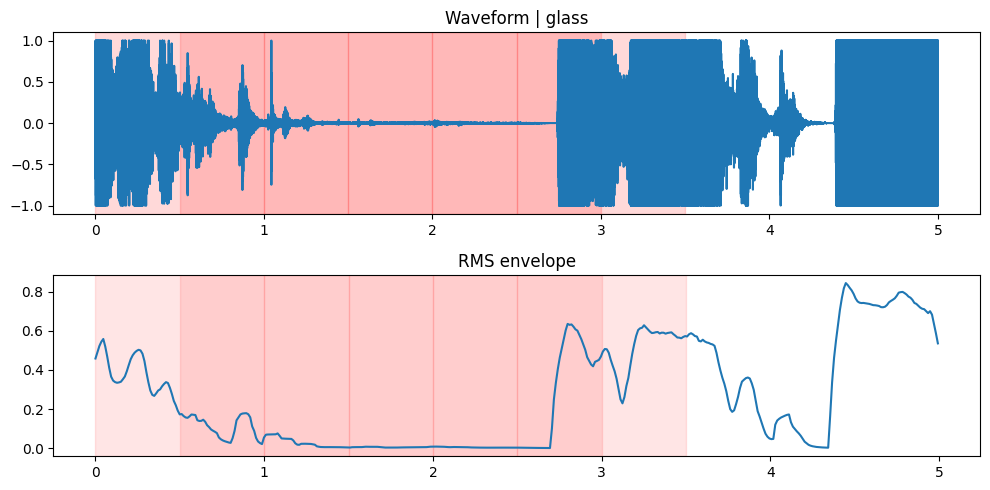

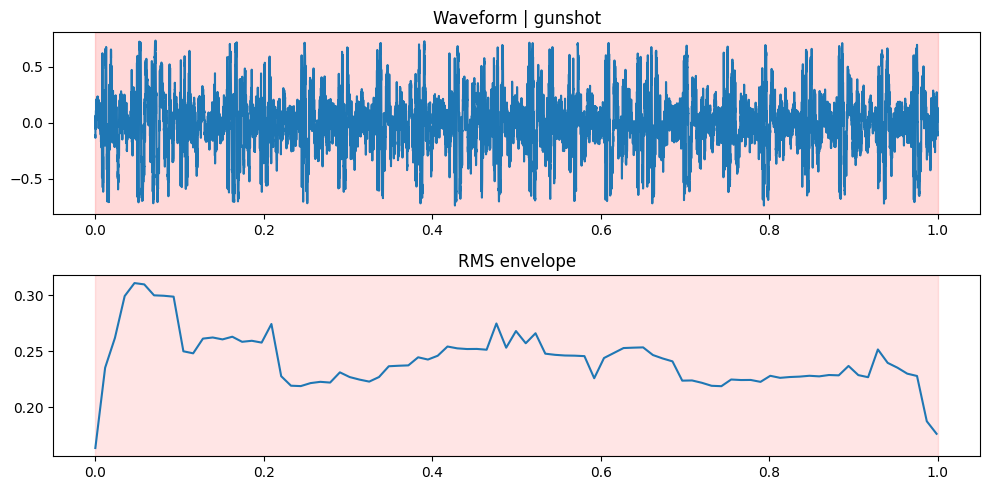

In [16]:
def plot_windows_for_row(row):
    y, sr = load_audio(row, sr=TARGET_SR)
    rms = librosa.feature.rms(y=y, frame_length=2048, hop_length=256)[0]
    wins = generate_aligned_windows(
        row,
        align_labels=['glass','gunshot'],
        extra_shifts=EXTRA_SHIFTS,
        energy_threshold=ENERGY_THRESHOLD,
        peak_ratio_threshold=PEAK_RATIO_THRESHOLD,
        front_peak_ratio=FRONT_PEAK_RATIO,
        trim_silence_before=TRIM_SILENCE_BEFORE,
        trim_top_db=TRIM_TOP_DB,
        trim_min_keep_seconds=TRIM_MIN_KEEP_SECONDS,
    )
    fig, ax = plt.subplots(2,1, figsize=(10,5), sharex=False)
    times = np.arange(len(y))/sr
    ax[0].plot(times, y)
    ax[0].set_title('Waveform | {}'.format(row.get('target_label','')))
    rms_times = np.arange(len(rms)) * 256 / sr
    ax[1].plot(rms_times, rms)
    ax[1].set_title('RMS envelope')
    for idx, _ in enumerate(wins):
        start = idx * WINDOW_HOP
        end = start + WINDOW_SECONDS
        ax[0].axvspan(start, end, color='red', alpha=0.15)
        ax[1].axvspan(start, end, color='red', alpha=0.1)
    plt.tight_layout(); plt.show()

glass_row = folded_df[folded_df['target_label']=='glass'].sample(random_state=SEED).iloc[0]
gun_row = folded_df[folded_df['target_label']=='gunshot'].sample(random_state=SEED).iloc[0]
plot_windows_for_row(glass_row)
plot_windows_for_row(gun_row)


## Play 10 event windows / 播放10个事件窗口
Play up to 10 kept windows (glass/gunshot) for quick QA. 播放最多10个保留窗口，便于快速听检。


In [17]:
clips = folded_df[folded_df['target_label'].isin(['glass','gunshot'])].sample(frac=1.0, random_state=SEED)
played = 0
for _, row in clips.iterrows():
    wins = generate_aligned_windows(
        row,
        align_labels=['glass','gunshot'],
        extra_shifts=EXTRA_SHIFTS,
        energy_threshold=ENERGY_THRESHOLD,
        peak_ratio_threshold=PEAK_RATIO_THRESHOLD,
        front_peak_ratio=FRONT_PEAK_RATIO,
        trim_silence_before=TRIM_SILENCE_BEFORE,
        trim_top_db=TRIM_TOP_DB,
        trim_min_keep_seconds=TRIM_MIN_KEEP_SECONDS,
    )
    for w_idx, w in enumerate(wins):
        print('{} | {} | window {}'.format(row['target_label'], Path(row['filepath']).stem, w_idx))
        display(Audio(w, rate=TARGET_SR))
        played += 1
        if played >= 10:
            break
    if played >= 10:
        break
if played == 0:
    print('No windows to play')


gunshot | 1 (23) | window 0


glass | 1-84536-A-39 | window 0


glass | 1-84536-A-39 | window 1


gunshot | 5 (49) | window 0


gunshot | 5 (49) | window 1


gunshot | 5 (5) | window 0


gunshot | 5 (5) | window 1


glass | 4-204121-A-39 | window 0


glass | 2-141563-A-39 | window 0


glass | 3-216281-A-39 | window 0


## Cache prep / 缓存准备
- 规范 target_label 为 glass/gunshot/background，补齐 filename 字段。
- 打印标签/折分布，作为缓存输入。


In [18]:
CACHE_ALIGN_LABELS = TARGET_LABELS
cache_df = folded_df.copy()
cache_df['target_label'] = cache_df['canonical_label'].apply(lambda lab: lab if lab in CACHE_ALIGN_LABELS else BACKGROUND_LABEL)
print('Label counts (cache_df):', cache_df['target_label'].value_counts().to_dict())
print('Fold x label:', cache_df.pivot_table(index='fold_id', columns='target_label', values='filepath', aggfunc='count').fillna(0))


Label counts (cache_df): {'background': 1960, 'gunshot': 50, 'glass': 40}
Fold x label: target_label  background  glass  gunshot
fold_id                                 
1                    392      8       10
2                    392      8       10
3                    392      8       10
4                    392      8       10
5                    392      8       10


In [19]:
# Feature shape check / 特征形状检查
sample_row = cache_df[cache_df['target_label'].isin(['glass','gunshot'])].sample(random_state=SEED).iloc[0]
wins = generate_aligned_windows(
    sample_row,
    align_labels=['glass','gunshot'],
    extra_shifts=EXTRA_SHIFTS,
    energy_threshold=ENERGY_THRESHOLD,
    peak_ratio_threshold=PEAK_RATIO_THRESHOLD,
    front_peak_ratio=FRONT_PEAK_RATIO,
    trim_silence_before=TRIM_SILENCE_BEFORE,
    trim_top_db=TRIM_TOP_DB,
    trim_min_keep_seconds=TRIM_MIN_KEEP_SECONDS,
)
if not wins:
    print('No windows to inspect for shape')
else:
    mel = log_mel_spectrogram(wins[0], sr=TARGET_SR)
    print(f'log-mel shape: {mel.shape}; model input: (batch, 1, {mel.shape[0]}, {mel.shape[1]})')


log-mel shape: (64, 87); model input: (batch, 1, 64, 87)


## Augment plan & cache dirs / 增强计划与缓存目录
设定 pipeline、对齐标签、Smoke/Full 输出目录。

In [20]:
PIPELINE_PLAN = GLASS_PIPELINE_PLAN
ALIGN_LABELS = CACHE_ALIGN_LABELS
SMOKE_CACHE_DIR = CACHE_MEL64 / 'mel64_smoke_multi'
FULL_CACHE_DIR = CACHE_MEL64 / 'mel64_multi'
SMOKE_COUNTS = {'glass': 10, 'gunshot': 10, 'background': 20}
print('Pipeline:', PIPELINE_PLAN)
print('Smoke dir:', SMOKE_CACHE_DIR)
print('Full dir:', FULL_CACHE_DIR)


Pipeline: {'shift_gain': {'copies': 2}, 'stretch_reverb': {'copies': 2}, 'shift_mix': {'copies': 2}, 'filter_gain': {'copies': 2}, 'gain_mix': {'copies': 1}, 'stretch_filter': {'copies': 1}}
Smoke dir: /workspace/cache/mel64/mel64_smoke_multi
Full dir: /workspace/cache/mel64/mel64_multi


## Smoke cache build / Smoke 缓存
少量抽样快速验证切窗+增强，生成索引。

In [21]:
smoke_parts = []
for lbl, n in SMOKE_COUNTS.items():
    sub = cache_df[cache_df['target_label'] == lbl]
    if len(sub) == 0:
        continue
    take = min(n, len(sub))
    smoke_parts.append(sub.sample(n=take, random_state=SEED))
smoke_df = pd.concat(smoke_parts, ignore_index=True) if smoke_parts else pd.DataFrame()
print('Smoke clips per label:', smoke_df['target_label'].value_counts().to_dict())
SMOKE_CACHE_DIR.mkdir(parents=True, exist_ok=True)
cache_index_smoke = build_cache_index(
    smoke_df,
    pipeline_plan=PIPELINE_PLAN,
    cache_dir=SMOKE_CACHE_DIR,
    align_labels=ALIGN_LABELS,
    extra_shifts=EXTRA_SHIFTS,
    energy_threshold=ENERGY_THRESHOLD,
    peak_ratio_threshold=PEAK_RATIO_THRESHOLD,
    front_peak_ratio=FRONT_PEAK_RATIO,
    seed=SEED,
)
print('Smoke cache size:', len(cache_index_smoke))
display(cache_index_smoke['label'].value_counts())


Smoke clips per label: {'background': 20, 'glass': 10, 'gunshot': 10}
Smoke cache size: 456


label
glass         198
gunshot       154
background    104
Name: count, dtype: int64

## Listen: base vs aug (smoke) / 试听增强样本
抽样 glass/gunshot 各 1 条，播放 base 和各 pipeline 增强（mix 会抽背景）。


In [22]:
rng = np.random.default_rng(SEED)
bg_pool = cache_df[cache_df['target_label'] == BACKGROUND_LABEL]

def sample_bg_chunk(length):
    if bg_pool.empty:
        return None
    row = bg_pool.sample(random_state=SEED).iloc[0]
    y_bg, _ = load_audio(row, sr=TARGET_SR)
    if len(y_bg) < length:
        y_bg = np.pad(y_bg, (0, length - len(y_bg)))
    start = rng.integers(0, max(1, len(y_bg) - length + 1))
    return y_bg[start:start+length]

for lbl in ['glass','gunshot']:
    sub = cache_df[cache_df['target_label'] == lbl]
    if sub.empty:
        continue
    row = sub.sample(random_state=SEED).iloc[0]
    wins = generate_aligned_windows(
        row,
        align_labels=['glass','gunshot'],
        extra_shifts=EXTRA_SHIFTS,
        energy_threshold=ENERGY_THRESHOLD,
        peak_ratio_threshold=PEAK_RATIO_THRESHOLD,
        front_peak_ratio=FRONT_PEAK_RATIO,
        trim_silence_before=TRIM_SILENCE_BEFORE,
        trim_top_db=TRIM_TOP_DB,
        trim_min_keep_seconds=TRIM_MIN_KEEP_SECONDS,
    )
    if not wins:
        continue
    base = wins[0]
    print(f"Label={lbl} | clip={Path(row['filepath']).stem} | base")
    display(Audio(base, rate=TARGET_SR))
    for name, cfg in PIPELINE_PLAN.items():
        bg = None
        if 'mix' in PIPELINE_REGISTRY[name]:
            bg = sample_bg_chunk(len(base))
        aug = run_pipeline(base, name, background=bg)
        print(f" -> {name}")
        display(Audio(aug.audio, rate=TARGET_SR))
    print('-'*40)


Label=glass | clip=4-204777-B-39 | base


 -> shift_gain


 -> stretch_reverb


 -> shift_mix


 -> filter_gain


 -> gain_mix


 -> stretch_filter


----------------------------------------
Label=gunshot | clip=9 (37) | base


 -> shift_gain


 -> stretch_reverb


 -> shift_mix


 -> filter_gain


 -> gain_mix


 -> stretch_filter


----------------------------------------


## Full cache build / 全量缓存
对全部 clips 生成 mel 缓存与索引。耗时较长，确认参数后再跑。

In [23]:
FULL_CACHE_DIR.mkdir(parents=True, exist_ok=True)
cache_index_df = build_cache_index(
    cache_df,
    pipeline_plan=PIPELINE_PLAN,
    cache_dir=FULL_CACHE_DIR,
    align_labels=ALIGN_LABELS,
    extra_shifts=EXTRA_SHIFTS,
    energy_threshold=ENERGY_THRESHOLD,
    peak_ratio_threshold=PEAK_RATIO_THRESHOLD,
    front_peak_ratio=FRONT_PEAK_RATIO,
    seed=SEED,
)
print('Full cache size:', len(cache_index_df))
display(cache_index_df['label'].value_counts())


Full cache size: 11912


label
background    10471
gunshot         737
glass           704
Name: count, dtype: int64

## Fold balancing & export / 折内平衡与导出
按 3:3:4 近似比例平衡正例 vs 背景，导出索引供训练。

In [24]:
# target_ratio = pos / (pos+bg) based on RATIOS (3+3):(4) -> 0.6
target_ratio = (RATIOS['glass'] + RATIOS['gunshot']) / sum(RATIOS.values())
balanced_index_df = balance_folds(cache_index_df, target_ratio=target_ratio, random_state=SEED)
print('Balanced size:', len(balanced_index_df))
print('Label counts (balanced):', balanced_index_df['label'].value_counts().to_dict())
print('Fold x label (balanced):')
display(balanced_index_df.pivot_table(index='fold_id', columns='label', values='path', aggfunc='count').fillna(0))
balanced_path = FULL_CACHE_DIR / 'index_balanced.csv'
balanced_index_df.to_csv(balanced_path, index=False)
print('Saved to', balanced_path)


Balanced size: 2402
Label counts (balanced): {'background': 961, 'gunshot': 737, 'glass': 704}
Fold x label (balanced):


label    background  glass  gunshot
fold_id                            
1               154     88      143
2               191    176      110
3               176    121      143
4               176     88      176
5               264    231      165

Saved to /workspace/cache/mel64/mel64_multi/index_balanced.csv


## Next steps / 后续步骤- 先运行 smoke 缓存单元，确认窗口/增强/索引 OK。- 再跑全量缓存，生成并保存 balanced index CSV。- 在 train.ipynb 读取 index_balanced.csv，跑 smoke/full 训练与导出。